#  Jax

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap


import matplotlib.pyplot as plt

import matplotlib.cm as cm

In [2]:
def loss(w):
    x, y = w[0], w[1]
    return (((x - 2) + (y - 1)) ** 2) / 4 + (((x - 2) - (y - 1)) ** 2)

# Для графиков
def get_z(x, y):
    sh = x.shape
    z = loss([x, y])
    return z.reshape(sh)

grad_f = grad(loss, argnums=0)

In [3]:
min_v, max_v = -5, 5
delta = 0.1
x = np.arange(min_v, max_v, delta)
y = np.arange(min_v, max_v, delta)
X, Y = np.meshgrid(x, y)
Z = get_z(X, Y)



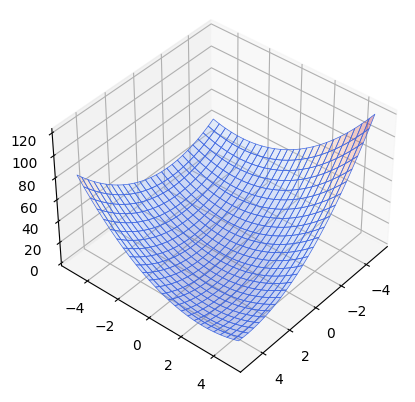

In [4]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, edgecolor='royalblue', lw=0.5, rstride=4, cstride=4, alpha=0.3)

ax.view_init(elev=40., azim=40)
plt.show()

In [5]:
def descent(w0, step_func, num_iters=100, eps=1e-5):
    w_prev, w = 0, jnp.copy(w0)
    l_prev, l = 0, loss(w)
    
    history = {'w': [w], 'loss': [l]}
    for i in range(1, num_iters + 1):
        w_new = step_func(w, w_prev, i)
        w_prev = w
        w = w_new
        
        l_prev = l
        l = loss(w)
        history['w'].append(w)
        history['loss'].append(l)
        if np.abs(l - l_prev) < eps:
            break
    
    return history

def unpack_history(history):
    x = [w.ravel()[0].item() for w in history['w']]
    y = [w.ravel()[1].item() for w in history['w']]
    z = [l.item() for l in history['loss']]
    
    return x, y, z

def grad_step(w, w_prev, i):
    return w - alpha * grad_f(w)

def momentum_step(w, w_prev, i):
    b = 0
    if i > 1:
        b = mu * (w - w_prev)
    return w - alpha * grad_f(w) + b

def nesterov_step(w, w_prev, i):
    y = w
    if i > 1:
        y += mu * (w - w_prev)
    return y - alpha * grad_f(y)

In [6]:
w0 = jnp.array([0, 4.5])
loss(w0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Array(30.8125, dtype=float32)

`GD vs GD + momentum`

In [7]:
alpha = 0.4
mu = 0.2

history_grad = descent(w0, grad_step)
history_momentum = descent(w0, momentum_step)

In [8]:
x_grad, y_grad, z_grad = unpack_history(history_grad)
x_momentum, y_momentum, z_momentum = unpack_history(history_momentum)

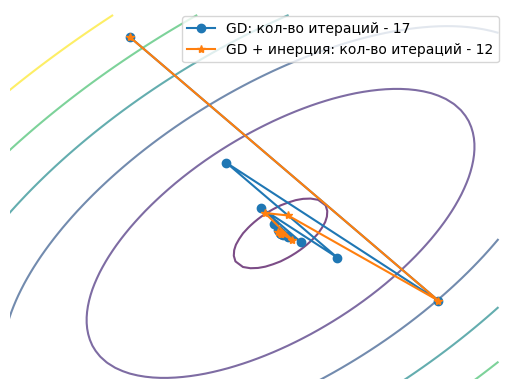

In [9]:
plt.contour(X, Y, Z, levels=np.quantile(Z, np.linspace(0.01, 0.8, 6)),  alpha=0.7)
plt.plot(x_grad, y_grad, marker='o', label=fr'GD: кол-во итераций - {len(x_grad)}')
plt.plot(x_momentum, y_momentum, marker='*', label=fr'GD + инерция: кол-во итераций - {len(x_momentum)}')

plt.axis('off')
plt.xlim(-1.6, 5)
plt.ylim(-1.6, 5)
plt.legend()
plt.savefig("GD1.svg")
plt.show()

`GD + momentum vs Nesterov GD`

In [10]:
alpha = 0.2
mu = 0.5

history_momentum = descent(w0, momentum_step)
history_nesterov = descent(w0, nesterov_step)

In [11]:
x_nesterov, y_nesterov, z_nesterov = unpack_history(history_nesterov)
x_momentum, y_momentum, z_momentum = unpack_history(history_momentum)

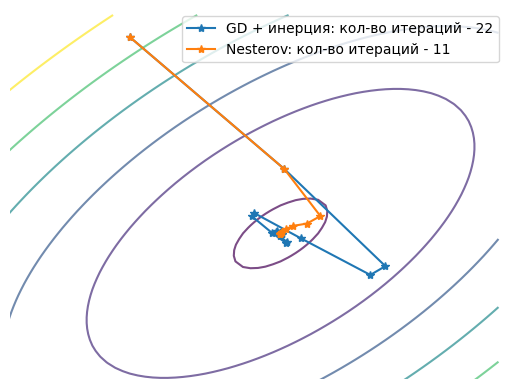

In [12]:
plt.contour(X, Y, Z, levels=np.quantile(Z, np.linspace(0.01, 0.8, 6)),  alpha=0.7)
plt.plot(x_momentum, y_momentum, marker='*', label=fr'GD + инерция: кол-во итераций - {len(x_momentum)}')
plt.plot(x_nesterov, y_nesterov, marker='*', label=fr'Nesterov: кол-во итераций - {len(x_nesterov)}')


plt.axis('off')
plt.xlim(-1.6, 5)
plt.ylim(-1.6, 5)
plt.legend()
plt.savefig("GD2.svg")
plt.show()

# CVXPY

Крайне рекомендуется изучить [документацию](https://www.cvxpy.org/index.html), она очень хорошая!

In [13]:
import cvxpy as cvx

# Вывод установленных солверов
print(cvx.installed_solvers())

from PIL import Image
import numpy as np

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


[Полный список](https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver) поддерживаемых солверов, под таблицей можно найти пояснения к задачам.

## Задача для примера

Есть изображение, некоторые пиксели которого исчезли (стали 0). Цель - восстановить исходное изображение

Формально, можем записать задачу следующим образом:

Наблюдается $U_{corr}$, известно $M$ - какие пиксели не испортились, цель найти $U$, такое что:

$U_{corr} \circ M = U \circ M$

Так как решений существует бесконечно много, мы хотим минизировать следующий функционал:

$\min_{U} \sum \limits_{i=1}^{m-1} \sum \limits_{j=1}^{n-1} \| (U_{i+1, j} - U_{i,j}, U_{i, j+1} - U_{i,j}) \|_2$

Такой функционал называется полной вариацией.

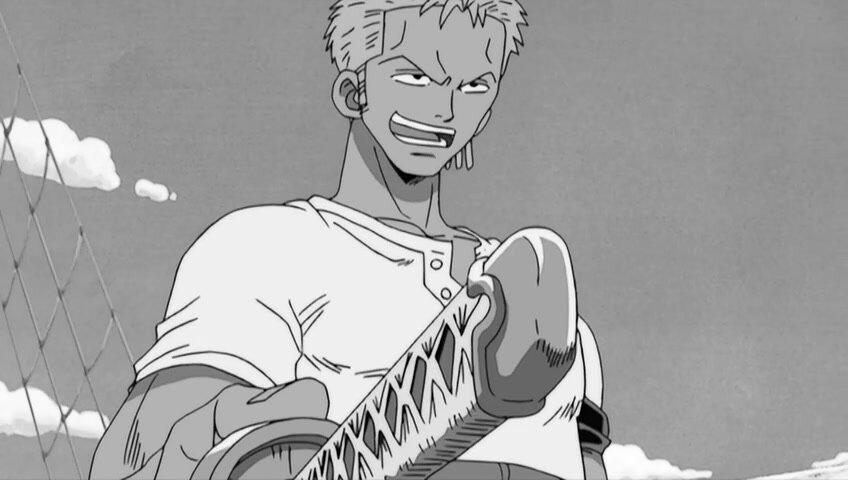

In [14]:
img = Image.open("./img.jpeg").convert('L')

img

In [15]:
p = 0.7

U_origin = np.array(img)[:]

np.random.seed(1)
mask = (np.random.rand(*U_origin.shape) > p).astype(np.int32)

U_corr = U_origin * mask

print(mask.mean()), U_origin.shape

0.30017197327044026


(None, (480, 848))

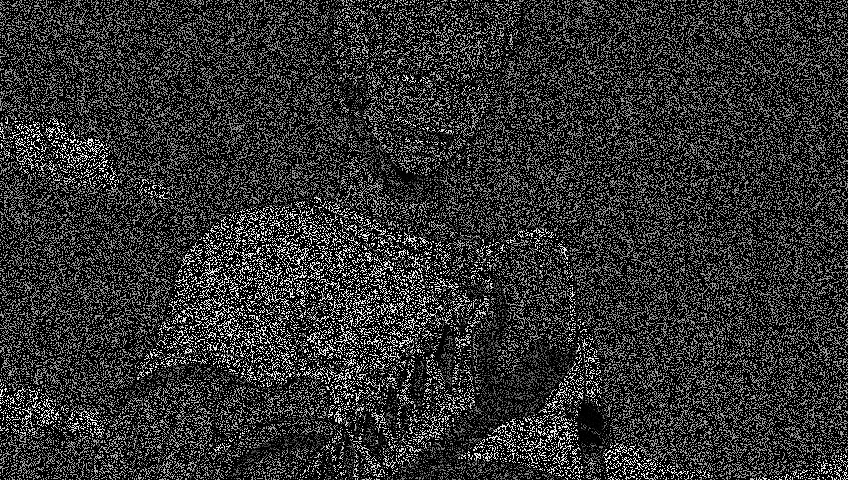

In [16]:
img_corr = Image.fromarray(np.uint8(U_corr))
img_corr

In [17]:
variables = []
constraints = []

    
U_var_ch = cvx.Variable(shape=U_corr.shape)
variables.append(U_var_ch)
    
constraints.append(cvx.multiply(mask, U_var_ch) == cvx.multiply(mask, U_corr))

In [18]:
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)

In [19]:
prob

Problem(Minimize(Expression(CONVEX, NONNEGATIVE, ())), [Equality(Expression(AFFINE, UNKNOWN, (480, 848)), Expression(CONSTANT, NONNEGATIVE, (480, 848)))])

In [20]:
%%time

prob.solve(verbose=True, solver=cvx.CLARABEL, max_iter=30)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 30 12:29:59 AM: Your problem has 407040 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 30 12:29:59 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 30 12:29:59 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 30 12:29:59 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 30 12:29:59 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 30 12:29:59 AM: Compiling problem (target solver=CLARABE

2241519.797203302

In [21]:
U_rec = np.array(U_var_ch.value, dtype=np.uint8)

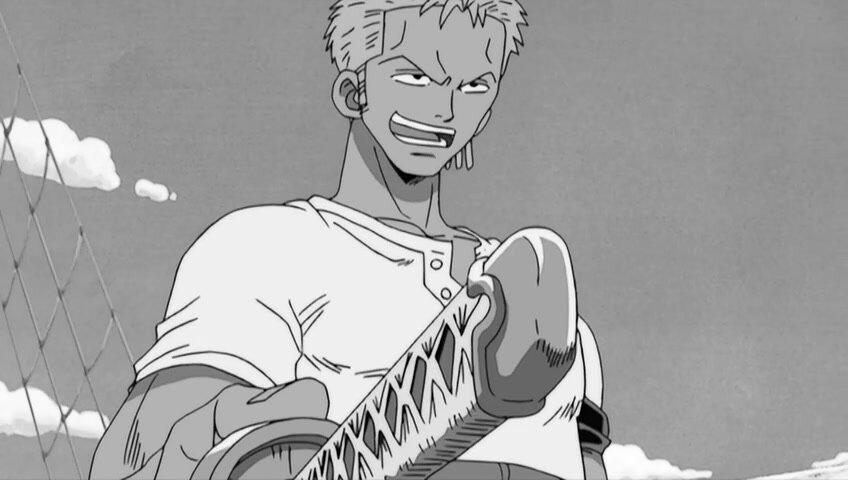

In [22]:
img = Image.open("./zoro.jpeg").convert('L')

img

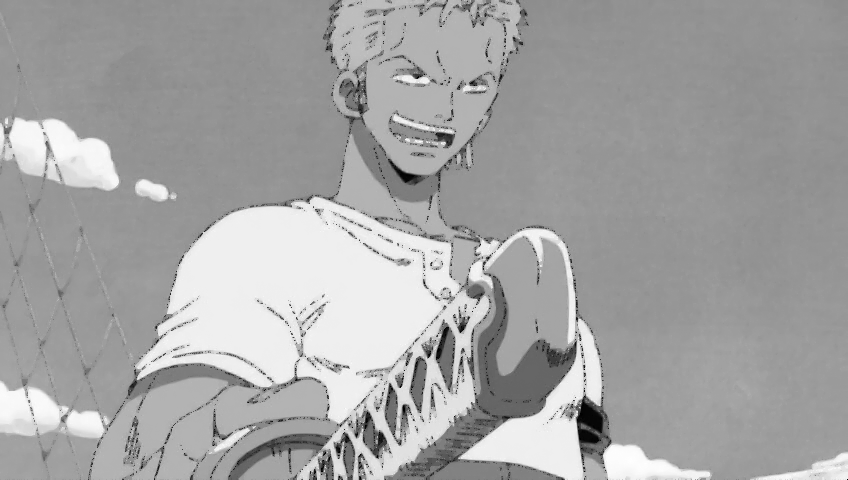

In [23]:
Image.fromarray(U_rec) # Изобрежение после реконструкции

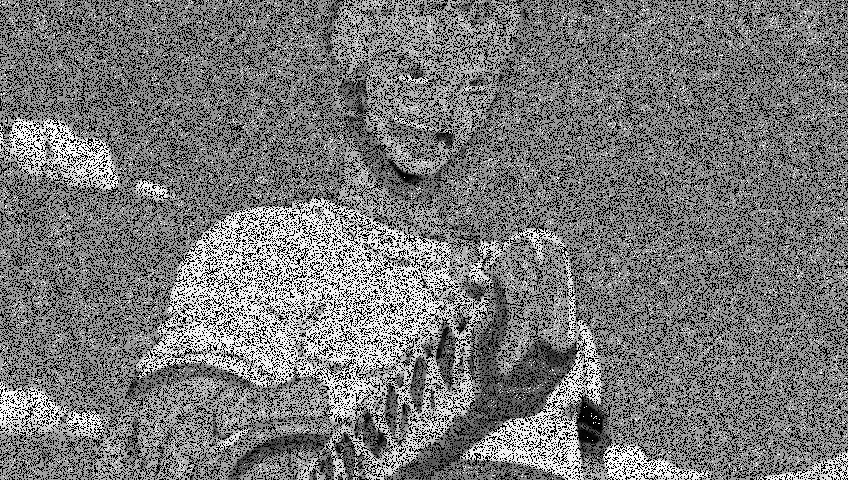

In [24]:
Image.fromarray(U_rec - U_corr.astype(np.uint8)) # Какие пиксели были исправлены